# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [3]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2019-05-16 18:45:46--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2019-05-16 18:45:51 (72.5 MB/s) - ‘mini_classes.txt’ saved [760/760]



Read the classes names 

In [0]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [42]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports 

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28
!ls data/

In [27]:
print(len(x_train))

0


Show some random data 

mountain


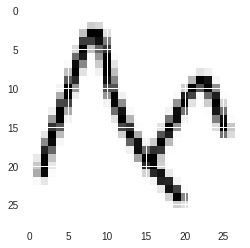

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [5]:
def kFold(root, i, vfold_ratio=0.2, max_items_per_class= 4000):
    from tensorflow.keras.callbacks import ModelCheckpoint, History
    import numpy as np
    import matplotlib.pyplot as plt
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []
    
    

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    print(class_names)
    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    num_classes = len(class_names)
    print(num_classes)
    image_size = 28
    # Reshape and normalize
    x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

    x_train /= 255.0
    x_test /= 255.0

    # Convert class vectors to class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    hist = History()
#     early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                    min_delta=0,
#                                                    patience=4,
#                                                    verbose=1, mode='auto')
    
        # Define model
    model = keras.Sequential()
    model.add(layers.Convolution2D(16, (3, 3),
                            padding='same',
                            input_shape=x_train.shape[1:], activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
    model.add(layers.MaxPooling2D(pool_size =(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(100, activation='softmax')) 
    # Train model
    adam = tf.train.AdamOptimizer()
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['top_k_categorical_accuracy'])
    print(model.summary())
    
    model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=10, callbacks=[hist])
    
    plt.style.use("ggplot")
    plt.figure()
    print(hist.history.keys())
    N = len(hist.history["val_top_k_categorical_accuracy"])
    #plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
    #plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), hist.history["top_k_categorical_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), hist.history["val_top_k_categorical_accuracy"], label="val_acc")
    plt.title("Training/Validation Accuracy on Doodle Classification" + str(i + 1))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("results" + str(i + 1) + ".png")
    
    return x_train, y_train, x_test, y_test, class_names
  
!ls data/

airplane.npy	  circle.npy	    key.npy	      shorts.npy
alarm_clock.npy   clock.npy	    knife.npy	      shovel.npy
anvil.npy	  cloud.npy	    ladder.npy	      smiley_face.npy
apple.npy	  coffee_cup.npy    laptop.npy	      snake.npy
axe.npy		  cookie.npy	    light_bulb.npy    sock.npy
baseball_bat.npy  cup.npy	    lightning.npy     spider.npy
baseball.npy	  diving_board.npy  line.npy	      spoon.npy
basketball.npy	  donut.npy	    lollipop.npy      square.npy
beard.npy	  door.npy	    microphone.npy    star.npy
bed.npy		  drums.npy	    moon.npy	      stop_sign.npy
bench.npy	  dumbbell.npy	    mountain.npy      suitcase.npy
bicycle.npy	  envelope.npy	    moustache.npy     sun.npy
bird.npy	  eyeglasses.npy    mushroom.npy      sword.npy
book.npy	  eye.npy	    pants.npy	      syringe.npy
bread.npy	  face.npy	    paper_clip.npy    table.npy
bridge.npy	  fan.npy	    pencil.npy	      tennis_racquet.npy
broom.npy	  flower.npy	    pillow.npy	      tent.npy
butterfly.npy	  frying_pan.npy    pizza.np

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [18]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

NameError: ignored

# Training 

['pizza', 'mushroom', 'star', 'drums', 'microphone', 'smiley_face', 'bicycle', 'cookie', 'sun', 'snake', 'eye', 'table', 'baseball_bat', 'shovel', 'rifle', 'key', 'lollipop', 'lightning', 'line', 'eyeglasses', 'helmet', 'envelope', 'tent', 'hot_dog', 'screwdriver', 'clock', 'chair', 'diving_board', 'moustache', 'fan', 'ceiling_fan', 'flower', 'baseball', 'ice_cream', 'rainbow', 'hammer', 'stop_sign', 'donut', 'candle', 'umbrella', 'shorts', 'suitcase', 'frying_pan', 'cell_phone', 'car', 'paper_clip', 'light_bulb', 'axe', 'broom', 'saw', 'bench', 'tooth', 'airplane', 'door', 'dumbbell', 'camera', 'scissors', 'pants', 'coffee_cup', 'moon', 'mountain', 'alarm_clock', 'syringe', 'wheel', 'hat', 'radio', 'square', 'traffic_light', 'bread', 'pillow', 'book', 'grapes', 'circle', 'bridge', 'beard', 't-shirt', 'headphones', 'cat', 'knife', 'power_outlet', 'spider', 'bed', 'sock', 'sword', 'spoon', 'tennis_racquet', 'cup', 'cloud', 'butterfly', 'face', 'apple', 'basketball', 'ladder', 'laptop', 

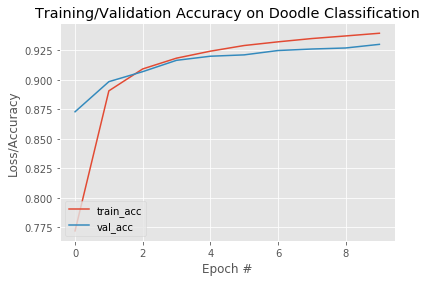

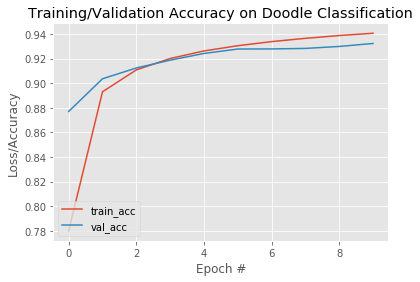

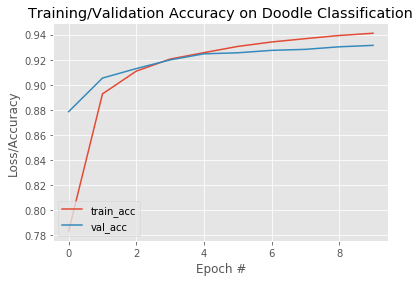

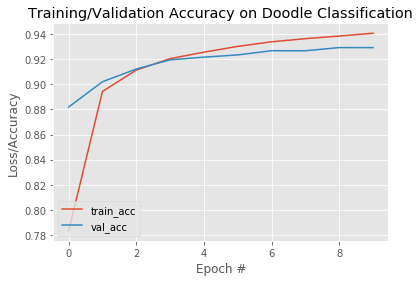

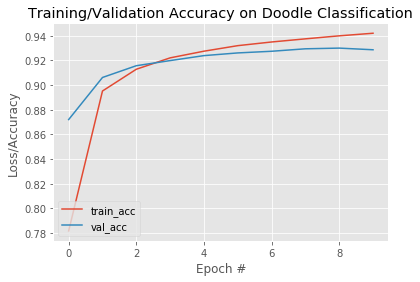

In [10]:
from google.colab import files
for i in range(0,5):
  kFold('data', i)
  #files.download("results" + str(i + 1) + ".png")

# Testing 

In [0]:
from google.colab import files
files.download("results1.png")
files.download("results2.png")
files.download("results3.png")
files.download("results4.png")
files.download("results5.png")
##score = model.evaluate(x_test, y_test, verbose=0)
##print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

# Inference 

['mountain', 'tent', 'rainbow', 'bridge', 'pants']


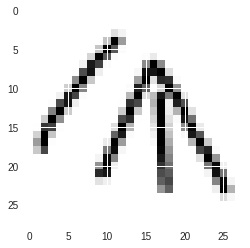

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [0]:
!pip install tensorflowjs 

    100% |████████████████████████████████| 61kB 10.9MB/s 
    100% |████████████████████████████████| 83.1MB 342kB/s 
    100% |████████████████████████████████| 307kB 16.9MB/s 
    100% |████████████████████████████████| 13.9MB 3.1MB/s 
    100% |████████████████████████████████| 3.1MB 11.6MB/s 
keras 2.2.2 has requirement keras-applications==1.0.4, but you'll have keras-applications 1.0.7 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.9 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: tensorflow-hub 0.3.0
    Uninstalling tensorflow-hub-0.3.0:
      Successfully uninstalled tens

# Save and Convert 

In [0]:
from google.colab import files
upload = files.upload()


Saving tensorflowjs_model.pb to tensorflowjs_model.pb


In [0]:
!tensorflowjs_converter --input_format=tf_frozen_model --output_node_names='final_result' tensorflowjs_model.pb web_model/

Using TensorFlow backend.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/importer.py", line 418, in import_graph_def
    graph._c_graph, serialized, options)  # pylint: disable=protected-access
tensorflow.python.framework.errors_impl.InvalidArgumentError: Cannot reshape a tensor with 1001 elements to shape [0,0] (0 elements) for 'MobilenetV1/Predictions/Reshape' (op: 'Reshape') with input shapes: [1,1001], [2] and with input tensors computed as partial shapes: input[1] = [0,0].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 10, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 352, in main
    strip_debug_ops=FLAGS.strip_debug_ops)
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/tf_saved_model_conversion_pb.py", line 32

# Zip and Download 

In [0]:
!zip -r model.zip web_model 

In [0]:
from google.colab import files
files.download('model.zip')